In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix,classification_report
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd

splits = {'train': 'split/train-00000-of-00001.parquet', 'validation': 'split/validation-00000-of-00001.parquet', 'test': 'split/test-00000-of-00001.parquet'}
df_train = pd.read_parquet("hf://datasets/dair-ai/emotion/" + splits["train"])
df_test = pd.read_parquet("hf://datasets/dair-ai/emotion/" + splits["test"])

In [3]:
df_train.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [4]:
df_train.label.value_counts()

,count
label,
1,5362
0,4666
3,2159
4,1937
2,1304
5,572


In [5]:
df_test.label.value_counts()

,count
label,
1,695
0,581
3,275
4,224
2,159
5,66


In [6]:
from sklearn.utils import resample

majority_class = df_train['label'].value_counts().idxmax()
minority_class = df_train['label'].value_counts().idxmin()

dfs = [df_train[df_train['label'] == i] for i in df_train['label'].unique()]

target_size = min(df_train['label'].value_counts())
balanced_dfs = [resample(d, replace=False, n_samples=target_size, random_state=42) if len(d) > target_size else d for d in dfs]

# Option 2: Oversample minority classes
# target_size = max(df['label'].value_counts())  # Set target size as the size of the largest class
# balanced_dfs = [resample(d, replace=True, n_samples=target_size, random_state=42) if len(d) < target_size else d for d in dfs]

# Combine balanced subsets
balanced_df = pd.concat(balanced_dfs)

# Shuffle the dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Check new class distribution
print(balanced_df['label'].value_counts())


label
2    572
5    572
1    572
4    572
3    572
0    572
Name: count, dtype: int64


In [7]:
from sklearn.utils import resample

majority_class = df_test['label'].value_counts().idxmax()
minority_class = df_test['label'].value_counts().idxmin()

dfs = [df_test[df_test['label'] == i] for i in df_test['label'].unique()]

target_size = min(df_test['label'].value_counts())
test_balanced_dfs = [resample(d, replace=False, n_samples=target_size, random_state=42) if len(d) > target_size else d for d in dfs]

# Option 2: Oversample minority classes
# target_size = max(df['label'].value_counts())  # Set target size as the size of the largest class
# balanced_dfs = [resample(d, replace=True, n_samples=target_size, random_state=42) if len(d) < target_size else d for d in dfs]

# Combine balanced subsets
test_balanced_df = pd.concat(test_balanced_dfs)

# Shuffle the dataset
test_balanced_df = test_balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Check new class distribution
print(test_balanced_df['label'].value_counts())


label
1    66
2    66
3    66
0    66
5    66
4    66
Name: count, dtype: int64


In [8]:
import re

# Simple text cleaning function
def simple_cleaning(text):
    if not isinstance(text, str):  # Handle non-string entries
        return ""
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    return text

# Apply the function
balanced_df['text'] = balanced_df['text'].apply(simple_cleaning)
test_balanced_df['text'] = test_balanced_df['text'].apply(simple_cleaning)
print("Text processing complete!")


Text processing complete!


In [9]:
balanced_df.dropna(inplace=True)
balanced_df.drop_duplicates(subset=['text'],inplace=True)
balanced_df.shape

(3429, 2)

In [10]:
balanced_df.isnull().sum()

,0
text,0
label,0


In [11]:
balanced_df.head()

,text,label
0,i love the feeling of being treasured to feel ...,2
1,im a creature of habit and major life changes ...,5
2,i have an ironic feel i dont feel anything spe...,1
3,i told justin a couple days ago that im feelin...,1
4,im getting there but i really do feel dazed an...,5


In [12]:
balanced_df.to_csv("cleaned_dataset.csv", index=False)

In [13]:
df1 = pd.read_csv("cleaned_dataset.csv")
df1.shape

(3429, 2)

In [14]:
df1.isnull().sum()

,0
text,0
label,0


In [15]:
df1.dropna(inplace=True)

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

# Separate features and target
X = df1['text']  # Feature column
y = df1['label']  # Target column

# Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer(max_features = 10000)  # Adjust max_features as needed
X_train_vectorized = vectorizer.fit_transform(X).toarray()
X_test_vectorized = vectorizer.transform(test_balanced_df['text']).toarray()

sacler = StandardScaler()
X_train_scaled = sacler.fit_transform(X_train_vectorized)
X_test_scaled = sacler.transform(X_test_vectorized)

# Save the processed datasets into a single .npz file
np.savez('processed_dataset.npz',
         X_train=X_train_scaled,
         X_test=X_test_scaled,
         y_train=y,
         y_test=test_balanced_df['label'])

print("Processed data saved successfully as 'processed_dataset.npz'.")


Processed data saved successfully as 'processed_dataset.npz'.


In [17]:
# Load the .npz file
data = np.load('processed_dataset.npz')

# Access the individual arrays
X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']

# Print the shapes of the original dataset
print("Original Data Shapes:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

# Reduce the dataset size by selecting a subset (e.g., 10%)
# subset_size = int(0.5 * X_train.shape[0])  # 10% of the dataset
# X_train_subsampled = X_train[:subset_size]
# y_train_subsampled = y_train[:subset_size]

# # Print the shapes of the reduced dataset
# print("\nReduced Data Shapes:")
# print("X_train_subsampled:", X_train_subsampled.shape)
# print("y_train_subsampled:", y_train_subsampled.shape)

# Now you can use the reduced dataset for training



Original Data Shapes:
X_train: (3429, 6671)
X_test: (396, 6671)
y_train: (3429,)
y_test: (396,)


In [18]:
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [19]:
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()
nb_model.fit(X_train_vectorized, y_train)
y_pred = nb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion matrix for Naive Bayes")
plt.show()

Accuracy: 0.696969696969697
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.65      0.68        66
           1       0.68      0.73      0.70        66
           2       0.69      0.76      0.72        66
           3       0.72      0.70      0.71        66
           4       0.74      0.73      0.73        66
           5       0.64      0.62      0.63        66

    accuracy                           0.70       396
   macro avg       0.70      0.70      0.70       396
weighted avg       0.70      0.70      0.70       396



In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion matrix for Random Forest")
plt.show()

Accuracy: 0.7904040404040404
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.70      0.69        66
           1       0.57      0.64      0.60        66
           2       0.86      0.89      0.87        66
           3       0.95      0.79      0.86        66
           4       0.91      0.77      0.84        66
           5       0.85      0.95      0.90        66

    accuracy                           0.79       396
   macro avg       0.80      0.79      0.79       396
weighted avg       0.80      0.79      0.79       396



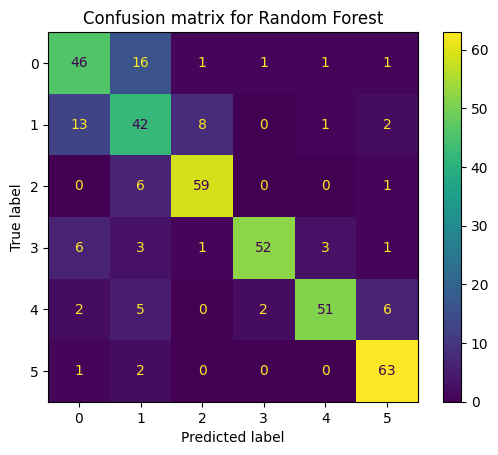

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion matrix for Logistic Regression")
plt.show()

Accuracy: 0.7272727272727273
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.71      0.71        66
           1       0.69      0.70      0.69        66
           2       0.76      0.76      0.76        66
           3       0.72      0.71      0.72        66
           4       0.78      0.68      0.73        66
           5       0.72      0.80      0.76        66

    accuracy                           0.73       396
   macro avg       0.73      0.73      0.73       396
weighted avg       0.73      0.73      0.73       396



In [25]:
import xgboost as xgb
xgboost_model = xgb.XGBClassifier(
    objective='multi:softmax',  # For multi-class classification
    num_class=6,                # Number of emotion classes (change if you have a different number)
    max_depth=6,                # Depth of the tree
    learning_rate=0.1,          # Learning rate
    n_estimators=100,           # Number of trees
    random_state=42
)

# Fit the model on the training data
xgboost_model.fit(X_train, y_train)

# Step 5: Make predictions on the test set
y_pred = xgboost_model.predict(X_test)

# Step 6: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion matrix for XGBoost")
plt.show()


Accuracy: 0.8207070707070707
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.76      0.74        66
           1       0.63      0.70      0.66        66
           2       0.88      0.89      0.89        66
           3       0.95      0.80      0.87        66
           4       0.95      0.83      0.89        66
           5       0.85      0.94      0.89        66

    accuracy                           0.82       396
   macro avg       0.83      0.82      0.82       396
weighted avg       0.83      0.82      0.82       396



In [33]:
# Import necessary libraries
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# Assume X_train, y_train, X_test, y_test are already defined

# Initialize base models
lr = LogisticRegression(max_iter=1000)
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Create a voting classifier (using soft voting for probability averaging)
voting_clf = VotingClassifier(estimators=[
    ('lr', lr),
    ('rf', rf),
], voting='soft')  # Use 'hard' for majority voting, 'soft' for probability averaging

# Train the Voting Classifier
voting_clf.fit(X_train, y_train)

# Make predictions
y_pred = voting_clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Voting Classifier Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_test, y_pred))


Voting Classifier Accuracy: 0.7904040404040404
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.77      0.76        66
           1       0.74      0.70      0.72        66
           2       0.82      0.80      0.81        66
           3       0.80      0.79      0.79        66
           4       0.84      0.82      0.83        66
           5       0.79      0.86      0.83        66

    accuracy                           0.79       396
   macro avg       0.79      0.79      0.79       396
weighted avg       0.79      0.79      0.79       396



HYPER TUNING RF MODEL

In [39]:
def predict_input_text(input_text):
    # Transform the input text using the same vectorizer that was used during training
    input_vector = vectorizer.transform([input_text])

    # Use the trained model to predict the class label
    prediction = voting_clf.predict(input_vector)

    return prediction[0]  # Return the predicted label

# Example usage
input_text ="I'm so lucky to have you in my life."
predicted_class = predict_input_text(input_text)

print(f"Predicted Class: {predicted_class}")

Predicted Class: 0


In [29]:
import joblib

joblib.dump(voting_clf, "emotion.pkl")

['emotion.pkl']